## FORCE training one Echo-state Network to mimic the output of another

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend, activations
 
import numpy as np
    
print(tf.__version__)

In [2]:
import tensorforce as force
from tensorforce import FORCEModel
from tensorforce.models import EchoStateNetwork


In [3]:
# Generate random parameters 

def random_esn_params(u, n, m, tau=1.0, dt=0.1, g=1.0):
  """Generate random RNN parameters
  
  Arguments: 
    u: dim of the input
    n: dim of the hidden state
    m: dim of the output
    tau: "neuronal" time constant
    dt: time between Euler integration updates
    g: scaling of the recurrent matrix in the reservoir

  Returns:
    A dictionary of parameters for the ESN.
  """

  #key, skeys = keygen(key, 5)
  hscale = 0.25
  ifactor = 1.0 / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  ffactor = 1.0 # Feedback factor, keep at 1 for now.
  return {'a0' : np.random.randn(n) * hscale,
          'wI' : np.random.randn(n,u) * ifactor,
          'wR' : np.random.randn(n,n) * hfactor,
          'wO' : np.random.randn(m,n) * pfactor,
          'wF' : np.random.randn(n,m) * ffactor,
          'dt_over_tau' : dt / tau}

In [35]:
T = 30              # total time
u = 3               # number of inputs
n = 500             # size of the reservoir in the ESN
tau = 1.0           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

x_t = np.zeros((ntime,u), dtype=np.float32) # Null input (internal dynamics only)
 
g = 1.5  # Lower g value was shown to be good in the paper for training.
m = 20
alpha = 1e0 # Initial learning rate for RLS

init_params = random_esn_params(u, n, m, g=g)

wI = tf.transpose(tf.convert_to_tensor(init_params['wI'], dtype=tf.float32))
wR = tf.transpose(tf.convert_to_tensor(init_params['wR'], dtype=tf.float32))
wF = tf.transpose(tf.convert_to_tensor(init_params['wF'], dtype=tf.float32))
wO = tf.transpose(tf.convert_to_tensor(init_params['wO'], dtype=tf.float32))

a0 = tf.cast(tf.convert_to_tensor(tf.expand_dims(init_params['a0'], axis = 0 )), tf.float32)
h = tf.tanh(a0)
z = backend.dot(h,wO)

input1 = tf.expand_dims(x_t,0)
init_state1 = (a0, h, z)

input2 = tf.concat([input1,input1,input1],axis=0)
init_state2 = tf.concat([a0,a0,a0],axis=0), tf.concat([h,h,h],axis=0), tf.concat([z,z,z],axis=0)

In [5]:

## Sketch of code for implementing the above in Keras

class FORCELayer(keras.layers.AbstractRNNCell):
    def __init__(self, units, output_size, activation, **kwargs):
        self.units = units 
        self._output_size = output_size
        self.activation = activations.get(activation)

        super().__init__(**kwargs)

    @property
    def state_size(self):
        return [self.units, self.units, self.output_size]

    @property 
    def output_size(self):
        return self._output_size

    def build(self, input_shape):
 
        self.input_kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                    initializer='uniform', trainable=False,
                                    name='input_kernel')
        self.recurrent_kernel = self.add_weight(
          shape=(self.units, self.units),
          initializer='uniform', 
          trainable=False,
          name='recurrent_kernel')
        self.feedback_kernel = self.add_weight(
          shape=(self.output_size, self.units), 
          initializer='uniform', 
          trainable=False,
          name='feedback_kernel')
        self.output_kernel = self.add_weight(
          shape=(self.units, self.output_size),
          initializer='uniform', trainable=True,
          name='output_kernel')      

        self.built = True

    @classmethod
    def from_weights(cls, weights, **kwargs):
        # Initialize the network from a list of weights (e.g., user-generated)
        input_kernel, recurrent_kernel, feedback_kernel, output_kernel = weights 
        input_shape, input_units = input_kernel.shape 
        recurrent_units1, recurrent_units2 = recurrent_kernel.shape 
        feedback_output_size, feedback_units = feedback_kernel.shape 
        output_units, output_size = output_kernel.shape 


        units = input_units 
        assert np.all(np.array([input_units, recurrent_units1, recurrent_units2, 
                            feedback_units, output_units]) == units)

        assert feedback_output_size == output_size 

        self = cls(units=units, output_size=output_size, **kwargs)
        self.input_kernel = self.add_weight(shape=(input_shape, self.units),
                                      initializer=keras.initializers.constant(input_kernel),
                                      trainable = False,
                                      name='input_kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer=keras.initializers.constant(recurrent_kernel),
            trainable = False,
            name='recurrent_kernel')
        self.feedback_kernel = self.add_weight(
            shape=(self.output_size, self.units),
            initializer=keras.initializers.constant(feedback_kernel),
            trainable = False,
            name='feedback_kernel')
        self.output_kernel = self.add_weight(
            shape=(self.units, self.output_size),
            initializer=keras.initializers.constant(output_kernel),
            trainable = True,
            name='output_kernel')      

        self.built = True

        return self

class EchoStateNetwork(FORCELayer):
    def __init__(self, dtdivtau, hscale = 0.25, seed = 0, **kwargs):
        self.dtdivtau = dtdivtau 
        self.hscale = hscale
        self.seed = 0

        super().__init__(**kwargs)        

    def call(self, inputs, states):
        """Implements the forward step (i.e., the esn() function)
        """
        
        prev_a, prev_h, prev_output = states

        input_term = backend.dot(inputs, self.input_kernel)
        recurrent_term = backend.dot(prev_h, self.recurrent_kernel)
        feedback_term = backend.dot(prev_output, self.feedback_kernel)

        dadt = -prev_a + input_term + recurrent_term + feedback_term 
        a = prev_a + self.dtdivtau * dadt
        h = self.activation(a)
        output = backend.dot(h, self.output_kernel)

        return output, [a, h, output]

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):

        initializer = keras.initializers.RandomNormal(mean=0., stddev= self.hscale , seed = self.seed)
        
        init_a = initializer((batch_size, self.units))  
        init_h =  self.activation(init_a)
        init_out = backend.dot(init_h,self.output_kernel) 
 
        return (init_a, init_h, init_out)
 


class FORCEModel(keras.Model):
    def __init__(self, force_layer, alpha_P=1.,return_sequences=True):
        super().__init__()
        self.alpha_P = alpha_P
        #self.input_layer = keras.Input(batch_shape=(1,300,1))

        self.force_layer = keras.layers.RNN(force_layer, 
                                            stateful=True, 
                                            return_state=True, 
                                            return_sequences=return_sequences)

        self.units = force_layer.units 
 
 

    def build(self, input_shape):

        self.P = self.add_weight(name='P', shape=(self.units, self.units), 
                                 initializer=keras.initializers.Identity(
                                              gain=self.alpha_P), trainable=True)
        super().build(input_shape)
 

    def call(self, x, training=False,   **kwargs):
        #x = self.input_layer(x)
        if training:
            return self.force_layer(x, **kwargs) 
        else:
            return self.force_layer(x, **kwargs)[0] 

    def train_step(self, data):
        # This is a standard keras method; see the Keras documentation for how this is used
        x, y = data
        for i in range(x.shape[1]):
          z, _, h, _ = self(x[:,i:i+1,:], training=True)

          if self.force_layer.return_sequences:
            z = z[:,0,:]

          # Compute pseudogradients
          trainable_vars = self.trainable_variables
          dP = self.__pseudogradient_P(h, z, y[:,i,:])

          # Update weights
          self.optimizer.apply_gradients(zip([dP], [trainable_vars[1]]))
          
          dwO = self.__pseudogradient_wO(h, z, y[:,i,:])
          
          # Update weights
          self.optimizer.apply_gradients(zip([dwO], [trainable_vars[0]]))

        # Update metrics (includes the metric that tracks the loss)
          self.compiled_metrics.update_state(y[:,i,:], z)
        # Return a dict mapping metric names to current value

        return {m.name: m.result() for m in self.metrics}


    def __pseudogradient_P(self, h, z, y):
        # Implements the training step i.e. the rls() function
        # This not a real gradient (does not use gradient.tape())
        # Computes the actual update
        # Example array shapes
        # h : 1 x 500
        # z : 1 x 20 
        # y : 1 x 20
        # P : 500 x 500 

        # k : 1 x 500 

        # e : 1 x 20

        # hPh : 1 x 500 . 500 x 1 = 1 x 1

        # dP : 500 x 500 
        # dw : 500 x 20  

        k = backend.dot(self.P, tf.transpose(h))
        hPht = backend.dot(h, k)
        c = 1./(1.+hPht)
        assert c.shape == (1,1)
        hP = backend.dot(h, self.P)
        dP = backend.dot(c*k, hP)
        
        return  dP 

    def __pseudogradient_wO(self, h, z, y):

        e = z-y
        Ph = backend.dot(self.P, tf.transpose(h))
        dwO = backend.dot(Ph, e)

        return  dwO

    def compile(self, metrics, **kwargs):
        super().compile(optimizer=keras.optimizers.SGD(learning_rate=1),  metrics=metrics)

    # def fit(self, x, y, epochs, verbose, **kwargs):
    #     if len(x.shape) < 3:
    #         x = tf.expand_dims(x, axis = 0)
        
    #     if len(y.shape) < 3:
    #         y = tf.expand_dims(y, axis = 0)
        
    #     if x.shape[0] != 1:
    #         raise ValueError("Dim 0 of x must be 1")

    #     if y.shape[0] != 1:
    #         raise ValueError("Dim 0 of y must be 1")
    #     if x.shape[1] != y.shape[1] 
    #         raise ValueError('Timestep dimension of inputs must match')     
        # super().fit(x = x, y = y, epochs = epochs, batch_size = 1, verbose = verbose, **kwargs)

    def predict(self, x, **kwargs):
        if len(x.shape) == 3 and x.shape[0] != 1:
            raise ValueError()
        
        if len(x.shape) < 3:
            x = tf.expand_dims(x, axis = 0)
        
        return self(x, training = False)[0] 

In [36]:
# Testing call

myesn = EchoStateNetwork.from_weights(weights = (wI, wR, wF, wO), 
                                      dtdivtau=init_params['dt_over_tau'], 
                                      activation = 'tanh')
model1 = FORCEModel(myesn, return_sequences=True)  
output = model1(x = input2, training = True  , initial_state = init_state2)
z_t = output[0] 
z_t_call = output[0][0]

In [31]:
init_params2 = random_esn_params(u, n, m, g=g)

wI2 = tf.transpose(tf.convert_to_tensor(init_params2['wI'], dtype=tf.float32))
wR2 = tf.transpose(tf.convert_to_tensor(init_params2['wR'], dtype=tf.float32))
wF2 = tf.transpose(tf.convert_to_tensor(init_params2['wF'], dtype=tf.float32))
wO2 = tf.transpose(tf.convert_to_tensor(init_params2['wO'], dtype=tf.float32))

a02 = tf.cast(tf.convert_to_tensor(tf.expand_dims(init_params2['a0'], axis = 0 )), tf.float32)
h2 = tf.tanh(a0)
z2 = backend.dot(h,wO)

input1 = tf.expand_dims(x_t,0)
init_state1 = (a02, h2, z2)

input2 = tf.concat([input1,input1,input1],axis=0)
init_state2 = tf.concat([a02,a02,a02],axis=0), tf.concat([h2,h2,h2],axis=0), tf.concat([z2,z2,z2],axis=0)

myesn2 = EchoStateNetwork.from_weights(weights = (wI2, wR2, wF2, wO2), 
                                      dtdivtau=init_params2['dt_over_tau'], 
                                      activation = 'tanh')

model2 = FORCEModel(myesn, return_sequences=True)

In [32]:
output2 = model2(x = input2, training = False, initial_state = init_state2)


In [33]:
# Define target function
f_t = output2[0]

Text(0, 0.5, 'Dimension')

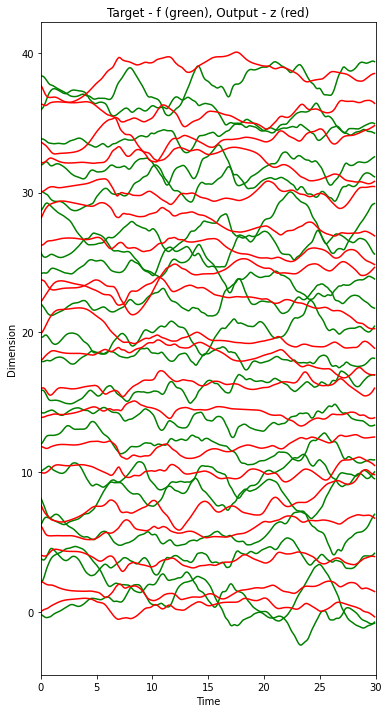

In [37]:
fig, ax1 = plt.subplots(figsize=(6,12))

ax1.plot(time, f_t + 2*np.arange(0, f_t.shape[1]), 'g')
ax1.plot(time, z_t_call + 2*np.arange(0, z_t_call.shape[1]), 'r');
ax1.set_xlim((0, T))
ax1.set_title('Target - f (green), Output - z (red)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Dimension')

In [39]:
# Testing fit

from keras.callbacks import History 
history = History()

ntraining = 5

myesn = EchoStateNetwork.from_weights(weights = (wI, wR, wF, wO), 
                                      dtdivtau=init_params['dt_over_tau'], 
                                      activation = 'tanh')

model1 = FORCEModel(myesn, return_sequences=True)  
model1.compile(metrics=["mae"])
res = model1.fit(x=input1,y= tf.expand_dims(tf.convert_to_tensor(f_t),axis = 0), epochs = ntraining, batch_size=1, verbose=False, callbacks=[history])

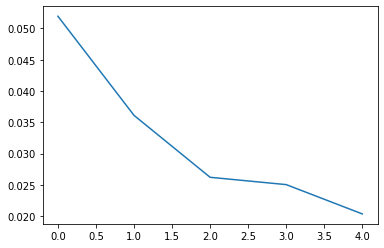

In [40]:
plt.plot(history.history['mae'])

In [41]:
z_t_call = model1.predict(input1)

Text(0, 0.5, 'Dimension')

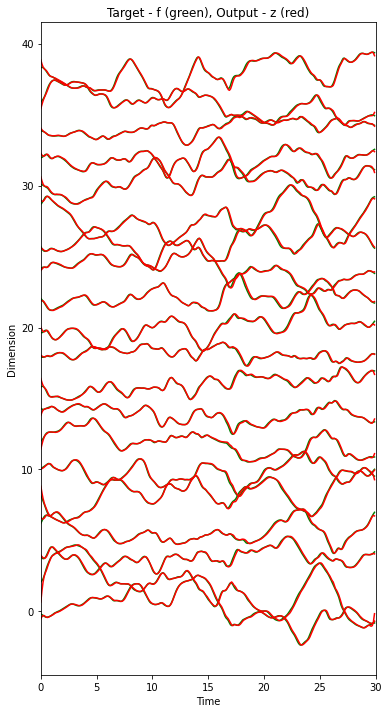

In [42]:
fig, ax1 = plt.subplots(figsize=(6,12))

ax1.plot(time , f_t  + 2*np.arange(0, f_t .shape[1]), 'g')
ax1.plot(time , z_t_call + 2*np.arange(0, z_t_call.shape[1]), 'r');
 
ax1.set_xlim((0, T))
ax1.set_title('Target - f (green), Output - z (red)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Dimension')